Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/home/avgus/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 16.5MB/s]



0: 544x640 1 car, 164.9ms
Speed: 28.8ms preprocess, 164.9ms inference, 8.6ms postprocess per image at shape (1, 3, 544, 640)


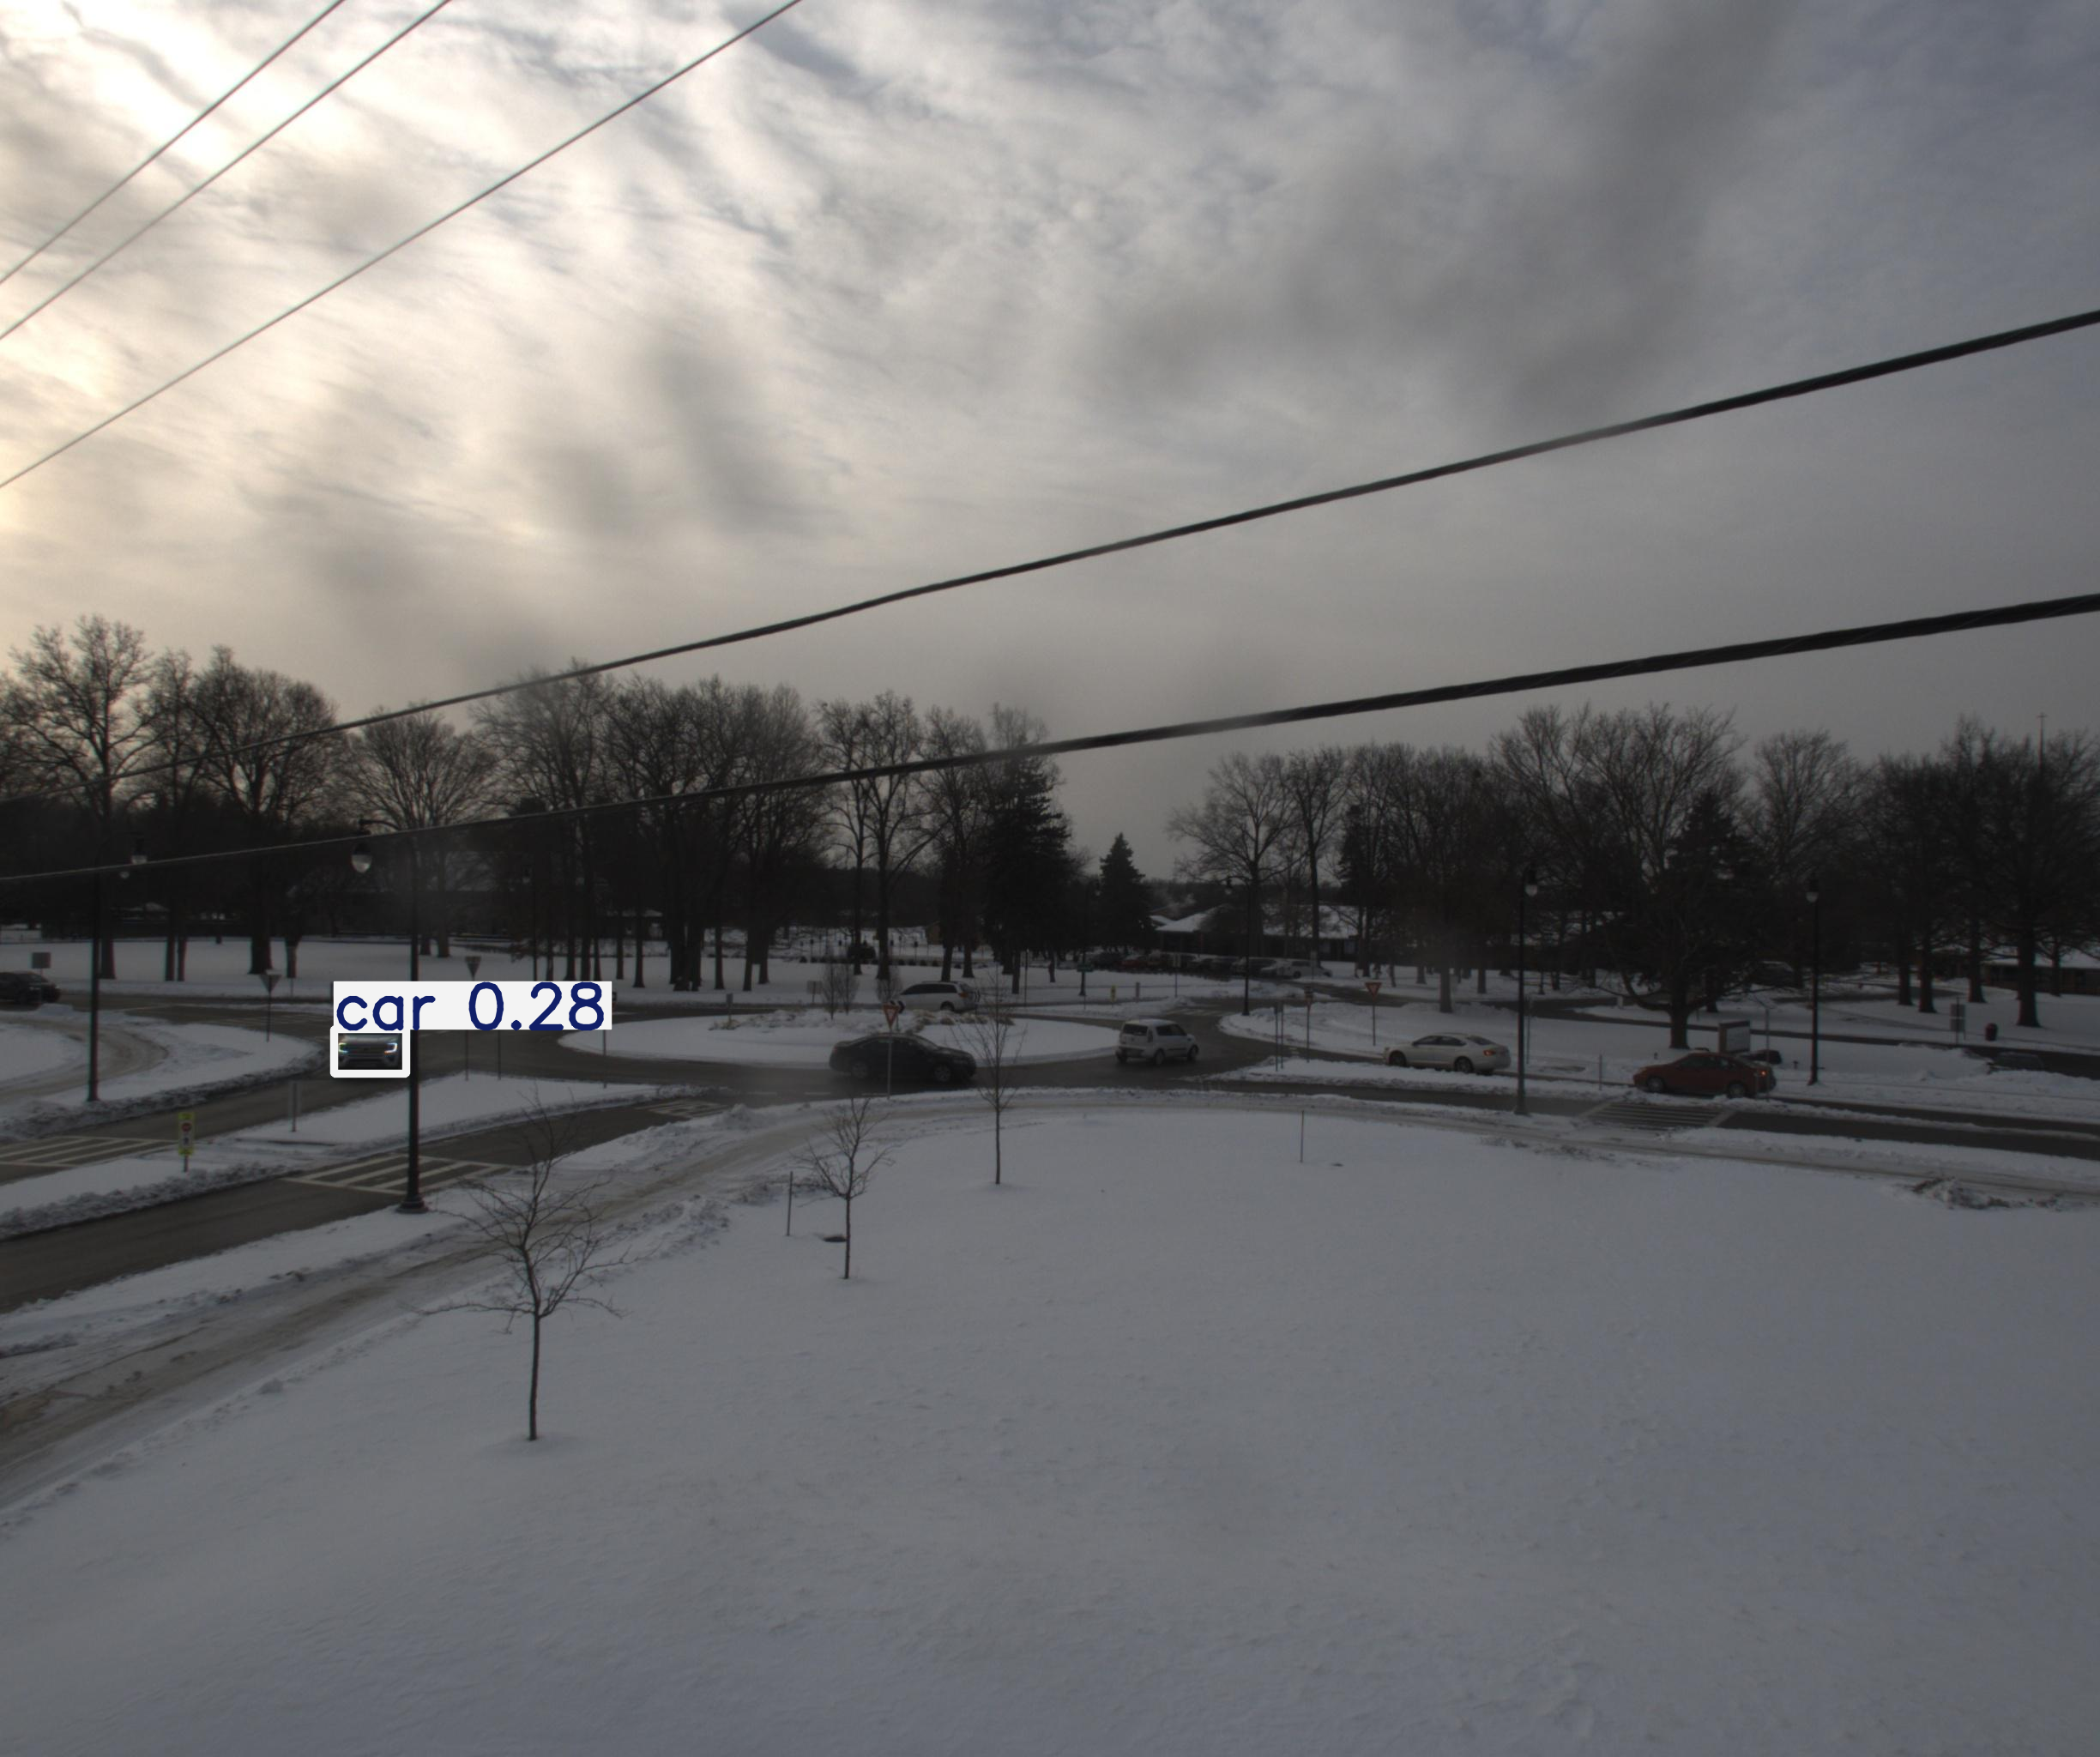

In [1]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n.pt")  # pretrained YOLO11n model

# Run batched inference on a list of images
results = model(["FOCAL/yolov5_format/images/test/nneo_pcd_customdata-s6nwj6hi-defaultproject-XdiZWkzxnCGM7xoqzFyStXcp_00625.pcd.jpg"])  # return a list of Results objects

# Process results list
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    obb = result.obb  # Oriented boxes object for OBB outputs
    result.show()  # display to screen
    result.save(filename="result.jpg")  # save to disk

In [3]:
for result in results:
    boxes = result.boxes  # Boxes object for bounding box outputs
    masks = result.masks  # Masks object for segmentation masks outputs
    keypoints = result.keypoints  # Keypoints object for pose outputs
    probs = result.probs  # Probs object for classification outputs
    print(probs)
    # result.show()  # display to screen


None


In [ ]:
results[0].boxes

tensor([0.2822])

In [29]:
import os
import json
import math
from ultralytics import YOLO
from tqdm import tqdm

# --- CONFIGURAÇÕES DE PARALELIZAÇÃO ---

# 1. Em quantas partes o conjunto 'train' será dividido?
TOTAL_DE_PARTES = 8

#>>>>> Altere este valor para cada execução: 0, 1, 2, ou 3 <<<<<
PARTE_ATUAL = 7

BATCH_SIZE = 25

DATASET_ROOT = 'FOCAL/yolov5_format'

FILE_LIST_PATH = 'FOCAL/image_paths.txt'

MODEL_NAME = 'yolov11n.pt'

LIGHTLY_TASK_NAME = 'object_detection'

# --- FIM DAS CONFIGURAÇÕES ---

# Construção dos caminhos com base nas configurações
IMAGES_DIR = os.path.join(DATASET_ROOT, 'images')
PREDICTIONS_ROOT_DIR = os.path.join(DATASET_ROOT, '.lightly', 'predictions', LIGHTLY_TASK_NAME)

print(f"Pasta de imagens do dataset: {IMAGES_DIR}")
print(f"Pasta onde as previsões serão salvas: {PREDICTIONS_ROOT_DIR}")
print("-" * 30)
print(f"CONFIGURAÇÃO DE LOTE: Processando a PARTE {PARTE_ATUAL + 1} de {TOTAL_DE_PARTES}")
print("-" * 30)

# Cria a estrutura de pastas para as previsões, se não existir
os.makedirs(PREDICTIONS_ROOT_DIR, exist_ok=True)

Pasta de imagens do dataset: FOCAL/yolov5_format/images
Pasta onde as previsões serão salvas: FOCAL/yolov5_format/.lightly/predictions/object_detection
------------------------------
CONFIGURAÇÃO DE LOTE: Processando a PARTE 8 de 8
------------------------------


In [30]:
# Célula 3: Carregamento do Modelo YOLOv8
print(f"Carregando o modelo: {MODEL_NAME}...")
model = YOLO("yolo11n.pt")  # pretrained YOLO11n model

Carregando o modelo: yolov11n.pt...


In [31]:
#Lógica de Processamento com Micro-Lotes

def generate_lightly_predictions(image_paths, output_dir, batch_size):
    """
    Executa a predição em uma lista de imagens, processando-as em pequenos lotes.
    """
    os.makedirs(output_dir, exist_ok=True)
    if not image_paths:
        print("Nenhuma imagem para processar nesta partição.")
        return

    print(f"\nIniciando predição para {len(image_paths)} imagens em lotes de {batch_size}...")
    
    # Cria uma barra de progresso geral
    with tqdm(total=len(image_paths), desc="Progresso Geral") as pbar:
        # Loop principal que divide a lista de arquivos em pequenos lotes (chunks)
        for i in range(0, len(image_paths), batch_size):
            # Pega o lote atual de caminhos de imagem
            chunk_paths = image_paths[i:i + batch_size]
            
            try:
                # Executa a predição APENAS para o lote pequeno
                results = model(chunk_paths, stream=True, verbose=False) # verbose=False para um output mais limpo

                # Processa o resultado de cada imagem no lote
                for result in results:
                    original_filename = os.path.basename(result.path)
                    
                    # Verifica se a predição para este arquivo já existe para evitar reprocessamento
                    output_json_path = os.path.join(output_dir, f"{os.path.splitext(original_filename)[0]}.json")
                    if os.path.exists(output_json_path):
                        pbar.update(1) # Atualiza a barra de progresso e pula
                        continue

                    # Cria a estrutura do JSON
                    lightly_data = { "file_name": original_filename, "predictions": [] }
                    boxes = result.boxes.xywh.cpu().numpy()
                    confidences = result.boxes.conf.cpu().numpy()
                    class_ids = result.boxes.cls.cpu().numpy().astype(int)

                    for j in range(len(boxes)):
                        prediction = {
                            "category_id": int(class_ids[j]),
                            "bbox": boxes[j].tolist(),
                            "score": float(confidences[j])
                        }
                        lightly_data["predictions"].append(prediction)
                    
                    # Salva o arquivo JSON
                    with open(output_json_path, 'w') as f:
                        json.dump(lightly_data, f, indent=4)
                    
                    # Atualiza a barra de progresso geral
                    pbar.update(1)

            except Exception as e:
                print(f"\nERRO ao processar o lote começando com a imagem: {chunk_paths[0]}")
                print(f"Erro: {e}")
                print("Aguardando 10 segundos antes de continuar com o próximo lote...")
                time.sleep(10)
                # Atualiza a barra de progresso para o lote que falhou para não travar
                pbar.update(len(chunk_paths))


In [32]:
split = 'train'
train_images_dir = os.path.join(IMAGES_DIR, split)

try:
    print(f"Lendo a lista de arquivos de: {FILE_LIST_PATH}")
    with open(FILE_LIST_PATH, 'r') as f:
        all_filenames = [line.strip() for line in f if line.strip()]

    all_image_files = [os.path.join(train_images_dir, f) for f in all_filenames]
    total_files = len(all_image_files)
    print(f"Total de arquivos carregados da lista: {total_files}")

    if total_files > 0:
        files_per_part = math.ceil(total_files / TOTAL_DE_PARTES)
        start = PARTE_ATUAL * files_per_part
        end = start + files_per_part
        files_to_process = all_image_files[start:end]

        print(f"Este notebook (Parte {PARTE_ATUAL + 1}/{TOTAL_DE_PARTES}) irá processar {len(files_to_process)} arquivos.")

        output_split_dir = os.path.join(PREDICTIONS_ROOT_DIR, split)
        # Chama a função de predição passando o tamanho do lote interno
        generate_lightly_predictions(files_to_process, output_split_dir, BATCH_SIZE)

except FileNotFoundError:
    print(f"ERRO: O arquivo de lista não foi encontrado em '{FILE_LIST_PATH}'.")

print("\nProcesso deste lote concluído!")

Lendo a lista de arquivos de: FOCAL/image_paths.txt
Total de arquivos carregados da lista: 76242
Este notebook (Parte 8/8) irá processar 9525 arquivos.

Iniciando predição para 9525 imagens em lotes de 25...


Progresso Geral: 100%|██████████| 9525/9525 [32:07<00:00,  4.94it/s]  


Processo deste lote concluído!


In [ ]:
# Célula 5: Verificação dos Arquivos Gerados (usando Python puro)
import pprint

def python_tree(startpath, max_level=4):
    """
    Função Python para replicar o comando 'tree -L <max_level>' de forma
    independente de plataforma.
    """
    prefix_item = '├── '
    prefix_last_item = '└── '
    prefix_indent = '│   '
    prefix_empty = '    '

    def recursive_walk(directory, prefix='', level=0):
        if level >= max_level:
            return

        # Lista os itens e ordena para uma exibição consistente
        try:
            files = sorted(os.listdir(directory))
        except OSError:
            # Não tem permissão para ler o diretório, etc.
            return
            
        # Itera sobre os arquivos, exceto o último
        for i, f in enumerate(files):
            is_last = i == (len(files) - 1)
            connector = prefix_last_item if is_last else prefix_item
            
            print(f"{prefix}{connector}{f}")

            path = os.path.join(directory, f)
            if os.path.isdir(path):
                # O prefixo para o próximo nível depende se este item é o último
                new_prefix = prefix + (prefix_empty if is_last else prefix_indent)
                recursive_walk(path, new_prefix, level + 1)

    print(startpath)
    recursive_walk(startpath)


# --- EXECUÇÃO DA VERIFICAÇÃO ---

print("Estrutura de arquivos de predição gerada (via Python):")
path_to_check = os.path.join(DATASET_ROOT, '.lightly')
python_tree(path_to_check, max_level=4)


# Tenta exibir o conteúdo de um arquivo de exemplo
try:
    example_file_path = None
    # A pasta de predições que acabamos de criar
    predictions_dir = os.path.join(path_to_check, 'predictions')
    for root, _, files in os.walk(predictions_dir):
        for file in files:
            if file.endswith('.json'):
                example_file_path = os.path.join(root, file)
                break
        if example_file_path:
            break

    if example_file_path:
        print(f"\nConteúdo do arquivo de exemplo: {example_file_path}")
        with open(example_file_path, 'r') as f:
            pprint.pprint(json.load(f))
    else:
        print("\nNenhum arquivo de predição JSON encontrado para exibir.")

except Exception as e:
    print(f"\nNão foi possível verificar os arquivos: {e}")

In [ ]:
import zipfile
import os

caminho_do_zip = 'jsons/jsons_parte_6.zip' 
diretorio_destino = 'FOCAL/yolov5_format/.lightly/predictions/object_detection/train' 


with zipfile.ZipFile(caminho_do_zip, 'r') as zip_ref:
    zip_ref.extractall(diretorio_destino)

print(f"'{caminho_do_zip}' descompactado com sucesso em '{diretorio_destino}/'")

'jsons/jsons_parte_6.zip' descompactado com sucesso em 'FOCAL/yolov5_format/.lightly/predictions/object_detection/train/'
